# Codespaces

Copilot codespaces is free for an edu account. It allows you to "upload" hints and source material. The [`hep-programming-hints`](https://github.com/gordonwatts/hep-programming-hints) repo was used. As the code had trouble running various things, that repo was updated (without re-running previously run questions). GPT 4.1 was used as the model. The [code space can be found here](https://github.com/copilot/spaces/gordonwatts/1) (this might not be accessible to anyone but me).

Note that when testing this was writing Release 25 code, and that was not yet released for ServiceX.

## Question 1: ETmiss

Prompt: `Plot the ETmiss of all events in the rucio dataset mc23_13p6TeV:mc23_13p6TeV.801167.Py8EG_A14NNPDF23LO_jj_JZ2.deriv.DAOD_PHYSLITE.e8514_e8528_a911_s4114_r15224_r15225_p6697`

[Codespace Query]()

Modifications:

* It mistakenly things you can access `met()` directly from the container rather than fetching the first MET object.
    * Added code to the hints database that details how to get at the missing et (re-running the query and it did it correctly).
* Removed the `ak.flatten`.
* Added the backend since `atlasr25` isn't on production yet.
* Added a `plt.show()` (which is ok - the instructions explicitly tell it not to do that).

Output()

c:\Users\gordo\Code\llms\atlas-plot-agent\.venv\Lib\site-packages\mplhep\utils.py:741: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()


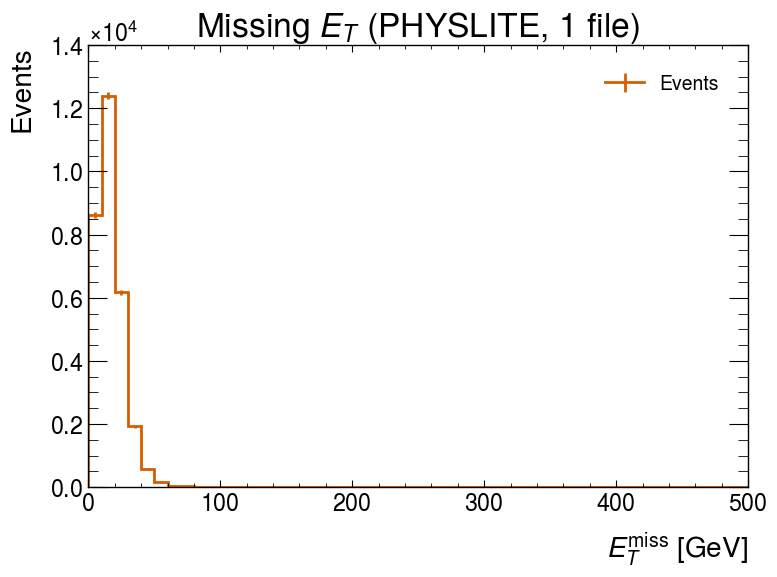

Saved ETmiss histogram as etmiss_hist.png


<Figure size 800x600 with 0 Axes>

In [1]:
import awkward as ak
import vector
import matplotlib.pyplot as plt
import mplhep as hep
from hist import Hist

from func_adl_servicex_xaodr25 import FuncADLQueryPHYSLITE
from servicex_analysis_utils import to_awk
from servicex import deliver, ServiceXSpec, Sample, dataset

# Register vector behaviors for awkward arrays (not strictly needed for ETmiss, but good practice)
vector.register_awkward()

# Step 1: Build the query to get ETmiss for each event
base_query = FuncADLQueryPHYSLITE()

# In PHYSLITE, MET is stored as a sequence per event; we want the first (and only) one
etmiss_query = base_query.Select(lambda e: e.MissingET().First()).Select(
    lambda met: {"etmiss": met.met() / 1000.0}
)  # GeV

# Step 2: Deliver the data from ServiceX (use only 1 file for quick test; remove NFiles for full dataset)
ds_name = "mc23_13p6TeV:mc23_13p6TeV.801167.Py8EG_A14NNPDF23LO_jj_JZ2.deriv.DAOD_PHYSLITE.e8514_e8528_a911_s4114_r15224_r15225_p6697"
result = to_awk(
    deliver(
        ServiceXSpec(
            Sample=[
                Sample(
                    Name="etmiss_fetch",
                    Dataset=dataset.Rucio(ds_name),
                    NFiles=1,  # Remove or increase for full production
                    Query=etmiss_query,
                )
            ]
        ),
        servicex_name="servicex-release-prod",
    )
)

etmiss = result["etmiss_fetch"].etmiss  # awkward array of ETmiss per event

# Step 3: Flatten and convert to numpy for histogramming
etmiss_flat = ak.to_numpy(etmiss)

# Step 4: Make the histogram
h = Hist.new.Reg(
    50, 0, 500, name="etmiss", label=r"$E_{T}^{\mathrm{miss}}$ [GeV]"
).Int64()
h.fill(etmiss=etmiss_flat)

# Step 5: Plot with mplhep
plt.style.use(hep.style.ATLAS)
fig, ax = plt.subplots()
h.plot(ax=ax, histtype="step", linewidth=2, label="Events")
ax.set_xlabel(r"$E_{T}^{\mathrm{miss}}$ [GeV]")
ax.set_ylabel("Events")
ax.set_title("Missing $E_T$ (PHYSLITE, 1 file)")
ax.legend()
plt.tight_layout()
plt.show()
plt.savefig("etmiss_hist.png")
print("Saved ETmiss histogram as etmiss_hist.png")

## Question 2: All Jets

Prompt: `Plot the jet pT for all jets in mc23_13p6TeV:mc23_13p6TeV.801167.Py8EG_A14NNPDF23LO_jj_JZ2.deriv.DAOD_PHYSLITE.e8514_e8528_a911_s4114_r15224_r15225_p6697`

Using this [codespace](https://github.com/copilot/spaces/gordonwatts/1). Here is the [query](https://github.com/copilot/c/1aab4eb2-2ee9-462f-a2d7-0cb18a099e47).

Modifications made to the raw code below:

* Remove the `ak.flatten` around the result (the `SelectMany` already does that). Initial attempts to alter the hints did not fix this problem.
* Added the backend since `atlasr25` isn't on production yet.
* Added a `plt.show()` (which is ok - the instructions explicitly tell it not to do that).

Output()

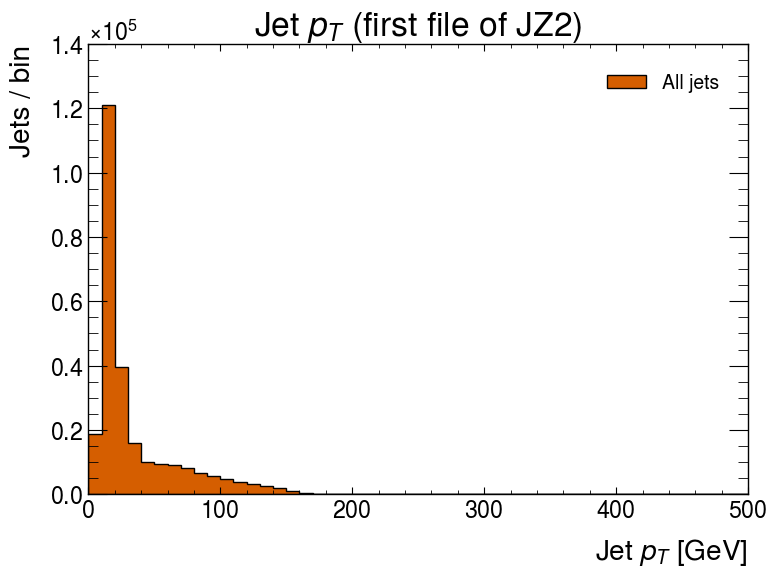

In [ ]:
import awkward as ak
import matplotlib.pyplot as plt
import mplhep as hep
from hist import Hist
from func_adl_servicex_xaodr25 import FuncADLQueryPHYSLITE
from servicex_analysis_utils import to_awk
from servicex import deliver, ServiceXSpec, Sample, dataset

# 1. Build the query for jet pt (in GeV) from the dataset
base_query = FuncADLQueryPHYSLITE()
jet_pts_query = (
    base_query
    .SelectMany(lambda evt: evt.Jets())
    .Select(lambda jet: {
        "jet_pt": jet.pt() / 1000.0,  # GeV
    })
)

ds_name = "mc23_13p6TeV:mc23_13p6TeV.801167.Py8EG_A14NNPDF23LO_jj_JZ2.deriv.DAOD_PHYSLITE.e8514_e8528_a911_s4114_r15224_r15225_p6697"

# 2. Fetch awkward array from ServiceX (limit to 1 file for speed)
all_jet_pts = to_awk(
    deliver(
        ServiceXSpec(
            Sample=[
                Sample(
                    Name="jet_pt_fetch",
                    Dataset=dataset.Rucio(ds_name),
                    NFiles=1,
                    Query=jet_pts_query,
                )
            ]
        ),
    )
)

# 3. Extract jet pT values
jet_pt = all_jet_pts["jet_pt_fetch"].jet_pt

# 4. Build the histogram for jet pT (0 to 500 GeV, 50 bins)
hist_jet_pt = (
    Hist.new
        .Reg(50, 0, 500, name="jet_pt", label="Jet $p_T$ [GeV]")
        .Int64()
)
hist_jet_pt.fill(jet_pt=jet_pt)

# 5. Plot and save
plt.style.use(hep.style.ATLAS)
hist_jet_pt.plot(histtype="fill", linewidth=1, edgecolor="black", label="All jets")
plt.xlabel("Jet $p_T$ [GeV]")
plt.ylabel("Jets / bin")
plt.title("Jet $p_T$ (first file of JZ2)")
plt.legend()
plt.tight_layout()
plt.show()
plt.savefig("jet_pt.png")
plt.close()

## 3. Central jets

Prompt: `Plot the pT of jets with |η| < 1 in the rucio dataset mc23_13p6TeV:mc23_13p6TeV.801167.Py8EG_A14NNPDF23LO_jj_JZ2.deriv.DAOD_PHYSLITE.e8514_e8528_a911_s4114_r15224_r15225_p6697`

[Codespace Query](https://github.com/copilot/c/65bcb7d2-a047-47a9-9755-2194dee727b2)

Modifications:

- Remove the `ak.flatten`.
- note: it added `import vector` even though it didn't need it.
- Changed the servicex backend
- Add a `plt.show()`.

Output()

c:\Users\gordo\Code\llms\atlas-plot-agent\.venv\Lib\site-packages\mplhep\utils.py:741: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()


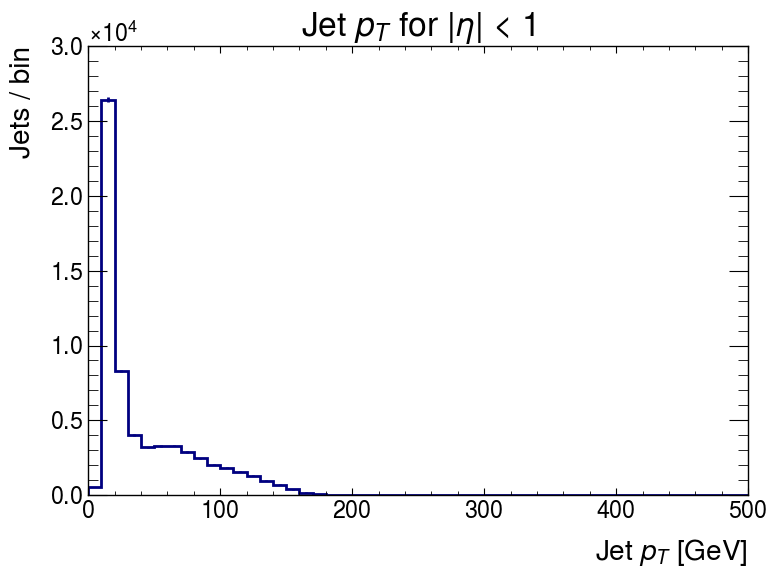

In [3]:
import awkward as ak
import vector
from func_adl_servicex_xaodr25 import FuncADLQueryPHYSLITE
from servicex_analysis_utils import to_awk
from servicex import deliver, ServiceXSpec, Sample, dataset
from hist import Hist
import matplotlib.pyplot as plt
import mplhep as hep

# Register vector behaviors for awkward arrays
vector.register_awkward()

# Define the dataset name
ds_name = "mc23_13p6TeV:mc23_13p6TeV.801167.Py8EG_A14NNPDF23LO_jj_JZ2.deriv.DAOD_PHYSLITE.e8514_e8528_a911_s4114_r15224_r15225_p6697"

# Define the query: get jets with |eta| < 1 and fetch their pt (in GeV)
base_query = FuncADLQueryPHYSLITE()
jet_query = (
    base_query.SelectMany(lambda evt: evt.Jets())
    .Where(lambda jet: abs(jet.eta()) < 1.0)
    .Select(
        lambda jet: {
            "pt": jet.pt() / 1000.0,  # Convert to GeV
        }
    )
)

# Deliver the query and fetch the results (use only 1 file for speed in demo; remove NFiles to run on all)
result = to_awk(
    deliver(
        ServiceXSpec(
            Sample=[
                Sample(
                    Name="jet_pt_eta_lt1",
                    Dataset=dataset.Rucio(ds_name),
                    NFiles=1,
                    Query=jet_query,
                )
            ]
        ),
        servicex_name="servicex-release-prod",
    )
)

# Extract pt awkward array
jet_pts = result["jet_pt_eta_lt1"].pt

# Plot histogram with Hist
h = Hist.new.Reg(50, 0, 500, name="pt", label="Jet $p_T$ [GeV]").Int64()
h.fill(pt=jet_pts)

plt.style.use(hep.style.ATLAS)
h.plot(histtype="step", linewidth=2, color="navy")
plt.xlabel(r"Jet $p_T$ [GeV]")
plt.ylabel("Jets / bin")
plt.title(r"Jet $p_T$ for |$\eta$| < 1")
plt.tight_layout()
plt.show()
plt.savefig("jet_pt_eta_lt1.png")
plt.close()

## 4. Missing ET of events with jets

Prompt: `Plot the ETmiss of events that have at least two jets with pT > 40 GeV in the rucio dataset mc23_13p6TeV:mc23_13p6TeV.801167.Py8EG_A14NNPDF23LO_jj_JZ2.deriv.DAOD_PHYSLITE.e8514_e8528_a911_s4114_r15224_r15225_p6697.`

[Codespace Query]()

Modifications:

- note: it added `import vector` even though it didn't need it.
- Changed the servicex backend
- Add a `plt.show()`.

Output()

c:\Users\gordo\Code\llms\atlas-plot-agent\.venv\Lib\site-packages\mplhep\utils.py:741: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()


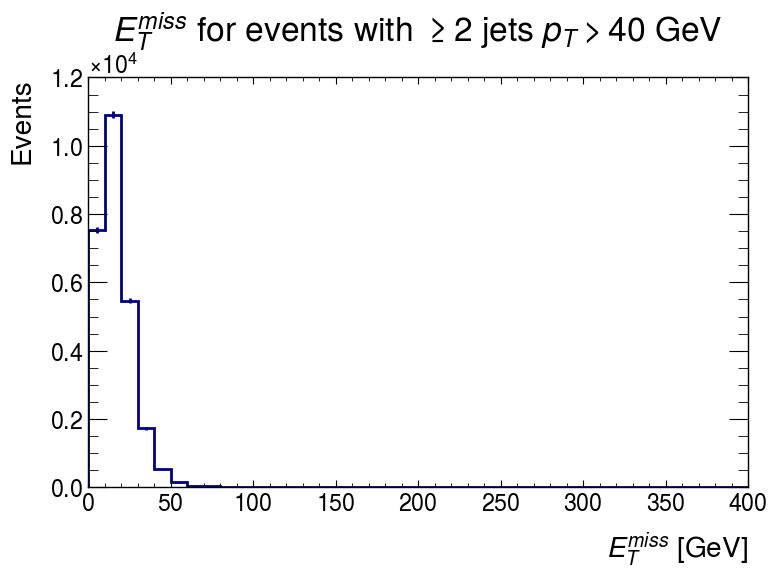

Saved plot to etmiss_hist.png


<Figure size 800x600 with 0 Axes>

In [4]:
import awkward as ak
import vector
from func_adl_servicex_xaodr25 import FuncADLQueryPHYSLITE
from servicex_analysis_utils import to_awk
from servicex import deliver, ServiceXSpec, Sample, dataset
from hist import Hist
import matplotlib.pyplot as plt
import mplhep as hep

# Register vector behaviors for awkward arrays
vector.register_awkward()

# Dataset name
ds_name = "mc23_13p6TeV:mc23_13p6TeV.801167.Py8EG_A14NNPDF23LO_jj_JZ2.deriv.DAOD_PHYSLITE.e8514_e8528_a911_s4114_r15224_r15225_p6697"

# Build the query: select events with >=2 jets with pt>40 GeV, get ETmiss
query = (
    FuncADLQueryPHYSLITE()
    .Where(lambda e: e.Jets().Where(lambda j: j.pt() / 1000.0 > 40.0).Count() >= 2)
    .Select(
        lambda e: {
            "met": e.MissingET().First().met() / 1000.0,  # ETmiss in GeV
        }
    )
)

# Deliver the data (for full dataset, remove NFiles)
result = to_awk(
    deliver(
        ServiceXSpec(
            Sample=[
                Sample(
                    Name="etmiss_jet",
                    Dataset=dataset.Rucio(ds_name),
                    NFiles=1,  # for quick test; set to None or remove for full statistics
                    Query=query,
                )
            ]
        ),
        servicex_name="servicex-release-prod",
    )
)

# Extract awkward array of ETmiss
etmiss = result["etmiss_jet"].met

# Make ETmiss histogram
h = Hist.new.Reg(40, 0, 400, name="etmiss", label="E_{T}^{miss} [GeV]").Double()
h.fill(etmiss=ak.to_numpy(etmiss))

# Plot with mplhep style
plt.style.use(hep.style.ATLAS)
fig, ax = plt.subplots()
h.plot(histtype="step", linewidth=2, ax=ax, color="navy")
ax.set_xlabel(r"$E_{T}^{miss}$ [GeV]")
ax.set_ylabel("Events")
ax.set_title(r"$E_{T}^{miss}$ for events with $\geq$2 jets $p_T>40$ GeV")
plt.tight_layout()
plt.show()
plt.savefig("etmiss_hist.png")
print("Saved plot to etmiss_hist.png")

## 5. Opposite sign pair of muons.

Prompt: `Plot the ETmiss of events that have an opposite-charge muon pair with an invariant mass between 60 and 120 GeV in the rucio dataset mc23_13p6TeV:mc23_13p6TeV.513109.MGPy8EG_Zmumu_FxFx3jHT2bias_SW_CFilterBVeto.deriv.DAOD_PHYSLITE.e8514_e8528_s4162_s4114_r14622_r14663_p6697.`

[Codespace Query](https://github.com/copilot/c/3636153e-fdbd-43c2-bd13-9fc0280a62fa)

Modifications:

- Changed the servicex backend
- Add a `plt.show()`.
- It fetched the muon mass even though it didn't need it (it could have been a constant).

In [ ]:
import awkward as ak
import vector
from func_adl_servicex_xaodr25 import FuncADLQueryPHYSLITE
from servicex_analysis_utils import to_awk
from servicex import deliver, ServiceXSpec, Sample, dataset

# Register awkward behaviors for Lorentz vectors
vector.register_awkward()

# Dataset name
ds_name = "mc23_13p6TeV:mc23_13p6TeV.513109.MGPy8EG_Zmumu_FxFx3jHT2bias_SW_CFilterBVeto.deriv.DAOD_PHYSLITE.e8514_e8528_s4162_s4114_r14622_r14663_p6697"

# Build query: for each event, select MET, and all muons' kinematics and charges
base_query = FuncADLQueryPHYSLITE()
query = base_query.Select(
    lambda e: {
        "met": e.MissingET().First().met() / 1000.0,  # MET in GeV
        "mu_pt": e.Muons().Select(lambda mu: mu.pt() / 1000.0),  # pt in GeV
        "mu_eta": e.Muons().Select(lambda mu: mu.eta()),
        "mu_phi": e.Muons().Select(lambda mu: mu.phi()),
        "mu_mass": e.Muons().Select(lambda mu: mu.m()),  # mass in MeV
        "mu_charge": e.Muons().Select(lambda mu: mu.charge()),
    }
)

# Fetch data (1 file for quick test; remove NFiles to run over all)
result = to_awk(
    deliver(
        ServiceXSpec(
            Sample=[
                Sample(
                    Name="evt_muons_met",
                    Dataset=dataset.Rucio(ds_name),
                    NFiles=1,
                    Query=query,
                )
            ]
        ),
    )
)

events = result["evt_muons_met"]

# Build Lorentz vectors for muons
muons = ak.zip(
    {
        "pt": events["mu_pt"],
        "eta": events["mu_eta"],
        "phi": events["mu_phi"],
        # Convert mass from MeV to GeV for consistency
        "mass": events["mu_mass"] / 1000.0,
    },
    with_name="Momentum4D",
)
mu_charge = events["mu_charge"]

# Find all unique pairs of muons in each event
pairs = ak.combinations(muons, 2, fields=["m1", "m2"], axis=1)
charge_pairs = ak.combinations(mu_charge, 2, fields=["q1", "q2"], axis=1)

# Opposite-charge mask
opp_charge = (charge_pairs["q1"] * charge_pairs["q2"]) < 0

# Invariant mass of each pair
pair_mass = (pairs["m1"] + pairs["m2"]).mass

# Mass window mask (60 < mass < 120 GeV)
mass_mask = (pair_mass > 60.0) & (pair_mass < 120.0)

# Both cuts: opposite charge and in mass window
pair_mask = opp_charge & mass_mask

# For each event, does there exist at least one pair passing both conditions?
has_good_pair = ak.any(pair_mask, axis=1)

# Select MET for events with at least one good pair
met_selected = events["met"][has_good_pair]

# -- Plotting --
import matplotlib.pyplot as plt
import hist
import mplhep as hep

plt.style.use(hep.style.ATLAS)

# Define histogram: 40 bins, 0-400 GeV
h = hist.Hist.new.Reg(40, 0, 400, name="met", label="$E_{T}^{miss}$ [GeV]").Double()

h.fill(met=ak.to_numpy(met_selected))

h.plot(histtype="step", linewidth=2, label=r"$E_{T}^{miss}$")
plt.xlabel(r"$E_{T}^{miss}$ [GeV]")
plt.ylabel("Events")
plt.legend()
plt.tight_layout()
plt.show()
plt.savefig("etmiss_opposite_charge_muonpair.png")

## 6. $tt$ all-jets invariant mass

Prompt: For events with at least three jets, plot the pT of the trijet four-momentum that has the invariant mass closest to 172.5 GeV in each event and plot the maximum b-tagging discriminant value among the jets in this trijet in the rucio dataset mc23_13p6TeV:mc23_13p6TeV.601237.PhPy8EG_A14_ttbar_hdamp258p75_allhad.deriv.DAOD_PHYSLITE.e8514_s4369_r16083_p6697.

Modifications:

**version 1**:

* First version didn't know how to get at the b-tagging information. Rather, it did the following: `"btag": jets.Select(lambda j: j.btag_DL1dv01())` - which makes so much more sense.
    * ATLAS b-tagging involves all sorts of tools - it isn't trivial - so will experiment with teaching the LLM this in version 2. But it would have been amazing if it knew how to get the discriminant.
* It made a 2D plot rather than a 2 1D plots.
    * Updated master prompt to make sure multiple plots were acceptable.
* It ran this with 10 files, not 1 file.
    - Tried to be more explicit about using NFiles=1 in the instructions.
* Large numbers of jets, etc., that came back meant large memory and large CPU time.
* It tried to use something called `ak.arrange`. Replacing it with `np.arrange` lead to some more "bad" behavior further down the way.

**version 2**:

* Even with updated files, GPT 4.1 didn't understand what it needed to do for the tool. The OpenAI 4o-mini model seemed to work.
* Wrote `from func_adl_servicex_xaodr25 import FuncADLQueryPHYSLITE, Jet_v1` - but for `Jet_v1` it really needed `from func_adl_servicex_xaodr25.xAOD.jet_v1 import Jet_v1`.
* Wrote `from func_adl.common import ObjectStream` - didn't need the `common`.
* Wrote `from func_adl.types import func_adl_callable` - didn't need the `types`
* Wrote `best_tri = tri_sum[best_idx]` which caused a slicing error.
    - The issue is subtle and has to do with the day that slicing works in awkward. What we need is:
    - `best_idx = ak.singletons(ak.argmin(delta, axis=1))`
    - `best_tri = ak.flatten(tri_sum[best_idx])`
    - `best_trip = ak.flatten(triplets[best_idx])`
    - The reason is that the argmin has to be able to deal with the empty list, so it puts a None in there, which means the return type for `argmin` is `?int64` - and that doesn't work with the slicing. So, `ak.singletons` will create a `[]` for each `None`, and then you can do the slicing properly. Finally, the `ak.flatten` gets rid of the extra indirection that `ak.singletons` adds.
    - Explaining this to the LLM is going to be complex!
* Tried to use `ak.stack`, but `np.stack` works fine.
* Wrote the following: `fourvecs = ak.zip({"pt": pts, "eta": etas, "phi": phis, "mass": ms}, with_name="Momentum4D"); jets_rec = ak.zip({"vec": fourvecs, "btag": btags})` It wrote that in two lines, it didn't need to do that - it could have done that in one line. And it adds another level of indirection (which it seems to track).
* Gets the limits for the b-tagging discriminant incorrect, assuming they are 0 to 1, but should be -10 to 15.

Output()

c:\Users\gordo\Code\llms\atlas-plot-agent\.venv\Lib\site-packages\mplhep\utils.py:741: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
c:\Users\gordo\Code\llms\atlas-plot-agent\.venv\Lib\site-packages\mplhep\utils.py:741: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()


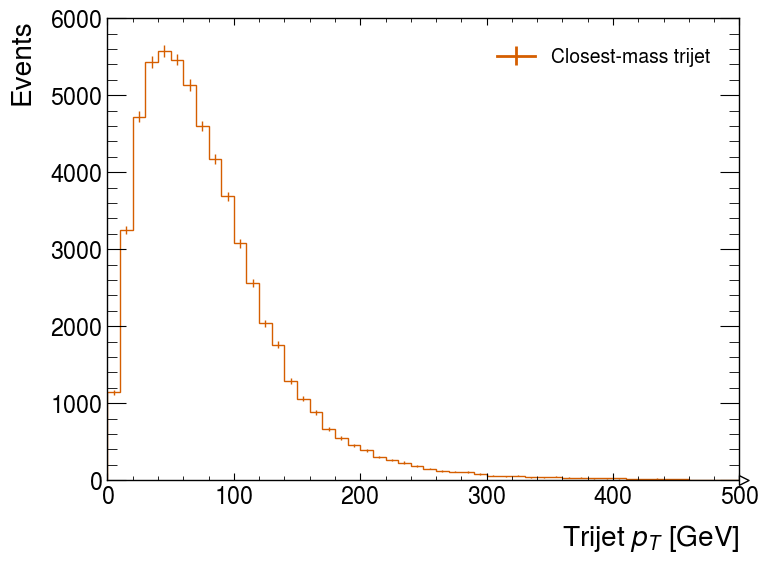

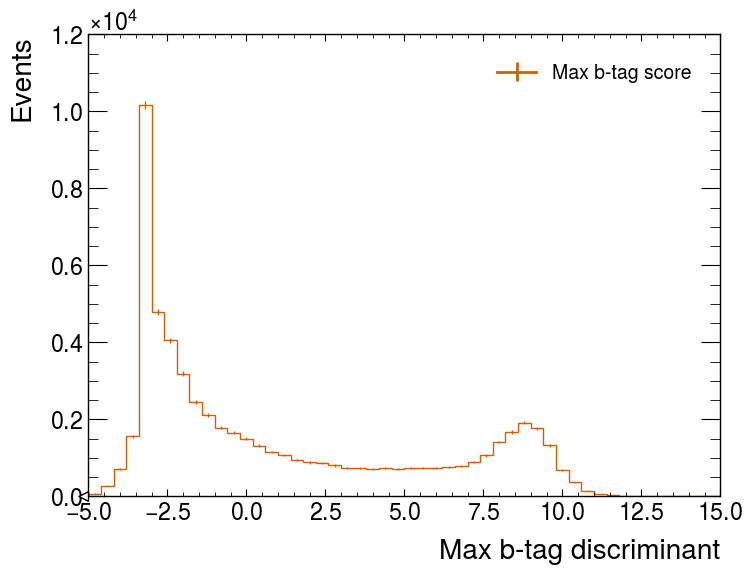

In [8]:
import awkward as ak
import numpy as np
import vector
import matplotlib.pyplot as plt
import mplhep as hep

from func_adl_servicex_xaodr25 import FuncADLQueryPHYSLITE
from func_adl_servicex_xaodr25.xAOD.jet_v1 import Jet_v1
from servicex_analysis_utils import to_awk
from servicex import deliver, ServiceXSpec, Sample, dataset
from hist import Hist

# 1) Prepare ServiceX query on PHYSLITE
base_query = FuncADLQueryPHYSLITE()

# 2) Inject the ATLAS default b-tagging tool at 77% efficiency
from dataclasses import dataclass
from typing import Optional, List, Tuple, Iterable, TypeVar
from func_adl import ObjectStream
from func_adl import func_adl_callable
import ast

T = TypeVar("T")

# -- xAOD Tool injection helpers (from xaod-hints.md) --
@dataclass
class ToolInfo:
    name: str

def make_a_tool(
    query: ObjectStream[T],
    tool_name: str,
    tool_type: str,
    include_files: Optional[List[str]],
    init_lines: List[str] = [],
) -> Tuple[ObjectStream[T], ToolInfo]:
    query_base = query.MetaData(
        {
            "metadata_type": "inject_code",
            "name": tool_name,
            "header_includes": include_files,
            "private_members": [f"{tool_type} *{tool_name};"],
            "instance_initialization": [
                f'{tool_name}(new {tool_type} ("{tool_name}"))'
            ],
            "initialize_lines": [l.format(tool_name=tool_name) for l in init_lines],
            "link_libraries": ["xAODBTaggingEfficiencyLib"],
        }
    )
    return query_base, ToolInfo(name=tool_name)

def make_tool_accessor(
    t_info: ToolInfo,
    function_name: str,
    source_code: List[str],
    arguments: Iterable[Tuple[str, type]],
    return_type_cpp: str,
    return_type_python: str
):
    def tool_callback(
        s: ObjectStream[T], a: ast.Call
    ) -> Tuple[ObjectStream[T], ast.Call]:
        new_s = s.MetaData(
            {
                "metadata_type": "add_cpp_function",
                "name": function_name,
                "code": [
                    "double result;",
                    *[l.format(tool_name=t_info.name) for l in source_code],
                ],
                "result": "result",
                "include_files": [],
                "arguments": [a[0] for a in arguments],
                "return_type": return_type_cpp,
            }
        )
        return new_s, a

    def tool_call(**arg_dict):
        ...
    tool_call.__name__ = function_name
    tool_call.__annotations__['return'] = eval(return_type_python)
    return func_adl_callable(tool_callback)(tool_call)

# Define and initialize BTaggingSelectionTool at 77% working point
physlite, tag_tool_info = make_a_tool(
    base_query,
    "btag_discriminator",
    "BTaggingSelectionTool",
    include_files=["xAODBTaggingEfficiency/BTaggingSelectionTool.h"],
    init_lines=[
        'ANA_CHECK(asg::setProperty({tool_name}, "OperatingPoint", "FixedCutBEff_77"));',
        "ANA_CHECK({tool_name}->initialize());",
    ],
)

# Provide an accessor to get the b-tag discriminant (double) for each jet
tag_weight = make_tool_accessor(
    tag_tool_info,
    function_name="tag_weight",
    source_code=["ANA_CHECK({tool_name}->getTaggerWeight(*jet, result, false));"],
    arguments=[("jet", Jet_v1)],
    return_type_cpp="double",
    return_type_python="float",
)

# 3) Build the query:
#    - Select only events with ≥3 jets
#    - For each event, return per-jet pt, eta, phi, mass (all in GeV) and the b-tag weight
query = (
    physlite
    .Where(lambda e: e.Jets().Count() >= 3)
    .Select(lambda e: {
        "pt":  e.Jets().Select(lambda j: j.pt()  / 1000.0),
        "eta": e.Jets().Select(lambda j: j.eta()),
        "phi": e.Jets().Select(lambda j: j.phi()),
        "m":   e.Jets().Select(lambda j: j.m()   / 1000.0),
        "btag": e.Jets().Select(lambda j: tag_weight(j)),
    })
)

# 4) Deliver the data (use NFiles=1 to test; remove to scan full dataset)
ds_name = ("mc23_13p6TeV:"
           "mc23_13p6TeV.601237.PhPy8EG_A14_ttbar_hdamp258p75_allhad."
           "deriv.DAOD_PHYSLITE.e8514_s4369_r16083_p6697")
out = to_awk(
    deliver(
        ServiceXSpec(
            Sample=[
                Sample(
                    Name="jets",
                    Dataset=dataset.Rucio(ds_name),
                    NFiles=1,
                    Query=query,
                )
            ]
        )
    )
)
# Extract the awkward arrays
jets = out["jets"]
pts   = jets.pt
etas  = jets.eta
phis  = jets.phi
ms    = jets.m
btags = jets.btag

# 5) Compute trijet combinations, pick the one closest to 172.5 GeV in each event
vector.register_awkward()  # enable vector methods on awkward arrays

# Build a per-jet Lorentz vector
fourvecs = ak.zip(
    {"pt": pts, "eta": etas, "phi": phis, "mass": ms},
    with_name="Momentum4D"
)
# Combine four-vectors and b-tags in one record
jets_rec = ak.zip({"vec": fourvecs, "btag": btags})

# All unique 3-jet combinations per event
triplets = ak.combinations(jets_rec, 3, fields=["j1","j2","j3"], axis=1)

# Sum the three four-vectors to get the trijet system
tri_sum = triplets.j1.vec + triplets.j2.vec + triplets.j3.vec
tri_mass = tri_sum.mass

# Find, for each event, the index of the trijet mass closest to 172.5 GeV
delta = abs(tri_mass - 172.5)
best_idx = ak.singletons(ak.argmin(delta, axis=1))

# Select the best trijet sum and the corresponding per-jet b-tags
best_tri = ak.flatten(tri_sum[best_idx])
best_trip = ak.flatten(triplets[best_idx])
best_btags = np.stack(
    [
        best_trip.j1.btag,
        best_trip.j2.btag,
        best_trip.j3.btag
    ],
    axis=1
)
max_btag = ak.max(best_btags, axis=1)

# # Flatten to 1D arrays of length = number of events
pt_values = ak.to_numpy(best_tri.pt)
btag_values = ak.to_numpy(max_btag)

# 6) Book histograms and fill
h_pt = (
    Hist.new
        .Reg(50, 0,   500, name="pt",    label="Trijet $p_T$ [GeV]")
        .Int64()
)
h_b = (
    Hist.new
        .Reg(50, -5.0, 15.0, name="btag", label="Max b-tag discriminant")
        .Int64()
)

h_pt.fill(pt=pt_values)
h_b.fill(btag=btag_values)

# 7) Plot and save
plt.style.use(hep.style.ATLAS)

plt.figure()
h_pt.plot(histtype="step", linewidth=1, label="Closest-mass trijet")
plt.xlabel("Trijet $p_T$ [GeV]")
plt.ylabel("Events")
plt.legend()
plt.savefig("trijet_pt.png")

plt.figure()
h_b.plot(histtype="step", linewidth=1, label="Max b-tag score")
plt.xlabel("Max b-tag discriminant")
plt.ylabel("Events")
plt.legend()
plt.savefig("max_btag_discriminant.png")